In [147]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
#from prophet import Prophet
pd.set_option('display.float_format', '{:.2f}'.format)
import xgboost as xgb

In [100]:
df = pd.read_csv('household_power_consumption.csv',sep=';',dtype='unicode')

In [101]:
# pr = Prophet()

In [102]:
df.dropna(inplace=True)

In [103]:
#df_gi = df[['Date','Global_active_power']].copy()

In [104]:
#df_gi.rename(columns={'Date':'ds', 'Global_active_power' : 'y'},inplace=True)

In [105]:
df[df['Date'] == '21/12/2006'][['Time']]

,Time
6156,00:00:00
6157,00:01:00
6158,00:02:00
6159,00:03:00
6160,00:04:00
...,...
7591,23:55:00
7592,23:56:00
7593,23:57:00
7594,23:58:00


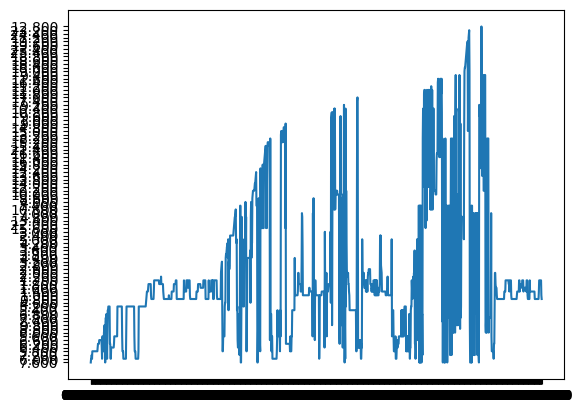

In [106]:
plt.plot(df[df['Date'] == '21/12/2006'].sort_values(by='Time')['Time'],df[df['Date'] == '21/12/2006'].sort_values(by='Time')['Global_intensity'])

In [107]:
#index_drop = df_gi[df_gi.y =='?'].index

In [108]:
#df_gi.drop(index_drop,inplace=True)

In [109]:
#df_gi.info()

In [110]:
#df_gi['ds'] = df_gi['ds'].apply(lambda x :datetime.datetime.strptime(x,'%d/%m/%Y'))

In [111]:
#df_gi_1kk = df_gi.iloc[0:100000,:].copy()

In [112]:
#pr.fit(df_gi_1kk)

In [113]:
#future = pr.make_future_dataframe(periods =7)

In [114]:
#future.tail()

Grupownie powyżej tyogdnia to nie ML

In [115]:
#forecast = pr.predict(future)

In [116]:
#forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [117]:
#fig1 = pr.plot(forecast)

In [118]:
#fig2= pr.plot_components(forecast)

In [119]:
df.describe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280,2049280,2049280,2049280,2049280,2049280,2049280,2049280,2049280
unique,1433,1440,4186,532,2837,221,88,81,32
top,2/12/2008,20:22:00,0.218,0.000,241.180,1.000,0.000,0.000,0.000
freq,1440,1427,9565,481561,3559,172785,1880175,1436830,852092


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 156.3+ MB


In [121]:
columns = df.iloc[:,2:].columns
columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [122]:
for i in columns:
    df[i] = round(df[i].astype('float64'),2)

In [123]:
df.dropna(inplace=True)

In [124]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.22,0.42,234.84,18.40,0.00,1.00,17.00
1,16/12/2006,17:25:00,5.36,0.44,233.63,23.00,0.00,1.00,16.00
2,16/12/2006,17:26:00,5.37,0.50,233.29,23.00,0.00,2.00,17.00
3,16/12/2006,17:27:00,5.39,0.50,233.74,23.00,0.00,1.00,17.00
4,16/12/2006,17:28:00,3.67,0.53,235.68,15.80,0.00,1.00,17.00


In [125]:
#df['Date'] = df['Date'].apply(lambda x :datetime.datetime.strptime(x,'%d/%m/%Y'))

Tworzenie zmiennych do modelu xgbooster

In [126]:
df['Global_active_power'] = df['Global_active_power'].apply(lambda x: (x*1000)/60) # ujednolicenie jednostek do wat/h


In [127]:
columns = ['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']
df_group = df.groupby(['Date'])[columns].sum().reset_index() # grupowanie po dacie czyli zuzycie dzienne

In [128]:
X = df_group[['Date','Sub_metering_1','Sub_metering_2','Sub_metering_3']] # zmienne opisujące
y = df_group[['Global_active_power']] #zmienna opisowa

In [129]:
df_group['Date'] = df_group['Date'].apply(lambda x :datetime.datetime.strptime(x,'%d/%m/%Y')) # zmiana formatu kolumny daty na timestam

In [130]:
df_group['Day_cal'] = df_group['Date'].apply(lambda x: x.weekday()) # dodanie zmiennej opisującej dzień tygodnia
df_group['Month'] = df_group['Date'].apply(lambda x: x.month) # dodanie zmiennej opisującej miesiąc

In [131]:
n = int(len(df_group.sort_values(by='Date')) * 0.75)
n
df_75 = df_group.sort_values(by='Date')[:n]
df_75
df_25 = df_group.sort_values(by='Date')[n:]
df_25

,Date,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Day_cal,Month
860,2009-11-26,26658.67,2262.00,407.00,10069.00,3,11
907,2009-11-27,22995.50,0.00,396.00,11599.00,4,11
953,2009-11-28,30984.33,3199.00,386.00,14350.00,5,11
1000,2009-11-29,27515.67,1073.00,3061.00,7828.00,6,11
1090,2009-11-30,29086.67,1080.00,361.00,12039.00,0,11
...,...,...,...,...,...,...,...
669,2010-11-22,34025.33,4855.00,2110.00,10136.00,0,11
717,2010-11-23,26292.83,1871.00,458.00,7611.00,1,11
765,2010-11-24,29936.33,1096.00,2848.00,12224.00,2,11
813,2010-11-25,23854.50,1076.00,426.00,5072.00,3,11


In [136]:
X_train = df_75.drop(labels='Global_active_power', axis=1)
X_test = df_25.drop(labels='Global_active_power', axis=1)
y_train = df_75[['Global_active_power']]
y_test = df_25[['Global_active_power']]

In [146]:
X_train.index.equals(y_train.index)

True

In [187]:
model_xgb = xgb.XGBRegressor(random_state = 1,n_estimators = 10000)

In [188]:
X = X_train.drop(labels='Date',axis=1)

In [189]:
model_xgb.fit(X,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [190]:
z = X_test.drop(labels='Date',axis=1)

In [191]:
y_pred = model_xgb.predict(z)

In [192]:
model_xgb.score(z,y_test)

0.6816328943263508